In [9]:
import pandas as pd
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.mllib.linalg import Vector, Vectors
#from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.clustering import LDA, LDAModel
import nltk
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import size
from pyspark.sql.functions import udf, col
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import udf, struct
import pyspark.sql.types as T 
import string
import nltk
from pyspark.sql import Row
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

import os
import sys
from pyspark.sql import SparkSession



In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark =SparkSession.builder.master("local[1]").appName('SparkProject').getOrCreate() 

21/12/10 11:48:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/10 11:48:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [10]:
#data  = spark.read.json(r"C:\Users\EndUser\Desktop\Data\AbhishekData\tweets.json")
#df = spark.read.json("tweets2.csv")
df = spark.read.json("tweets90.json")

In [11]:
df.head()

Row(content='.@VW will introduce heads-up display with augmented-reality in its upcoming #EVs. https://t.co/CINqosgiCD', date='2017-01-31T23:49:34+00:00', latitude=None, longitude=None, tweetid=826578200402616320, userid=1187313746, userlocation='')

In [12]:
df = df.dropDuplicates(['tweetid'])
df = df.na.drop()
df = df.filter("content != ''")
df = df.limit(100)

In [13]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_number(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet

def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet

In [14]:
from pyspark.sql.types import StringType

remove_emoji=udf(remove_emoji)
remove_users=udf(remove_users)
remove_number=udf(remove_number)

df=df.withColumn('content', remove_emoji(df['content']))
df=df.withColumn('content', remove_users(df['content']))
df=df.withColumn('content', remove_number(df['content']))

In [15]:

df = df.withColumn('content', F.regexp_replace('content', r'http\S+', ''))
df = df.withColumn('content', F.regexp_replace('content', '@\w+', ''))
df = df.withColumn('content', F.regexp_replace('content', '#', ''))
df = df.withColumn('content', F.regexp_replace('content', 'RT', ''))
df = df.withColumn('content', F.regexp_replace('content', ':', ''))
df = df.withColumn('content', F.regexp_replace('content', '\n', ''))
df = df.withColumn('content', F.regexp_replace('content', '|', ''))
df = df.withColumn('content', F.regexp_replace('content', '[^\sa-zA-Z0-9]', ''))
df = df.withColumn("content",F.lower('content'))
df = df.withColumn("content",F.rtrim('content'))

df = df.withColumn('Tweet_No', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)

In [16]:
df.head()

21/12/10 11:49:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0)

In [17]:
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("content").setOutputCol("tokens")

In [18]:
df = tokenizer.transform(df)


In [19]:
df.head()

21/12/10 11:49:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0, tokens=['european', 'fast', 'charging', 'networks', 'announce', 'fast', 'charging', 'alliance', 'evs'])

In [20]:
nltk.download('stopwords')
stopwordList = stopwords.words('english')
remover = StopWordsRemover(stopWords=stopwordList)
remover.setInputCol("tokens")
remover.setOutputCol("filtered")

df = remover.transform(df);


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bigdata/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    #row = [stemmer.stem(lemmatizer.lemmatize(word)) for word in row]
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

[nltk_data] Downloading package wordnet to /home/bigdata/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
lemmatization = udf(lemmatization)

df=df.withColumn('tokens', lemmatization(df['filtered']))



In [23]:
df.head()

21/12/10 11:50:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0, tokens='[european, fast, charge, network, announce, fast, charge, alliance, evs]', filtered=['european', 'fast', 'charging', 'networks', 'announce', 'fast', 'charging', 'alliance', 'evs'])

In [24]:
#sampling data for manual labelling
def get_sample(part=0.17):
    df = df.sample(part)
    df = df.select("tweetid", "content")
    df.coalesce(1).write.option("header", True).csv('sample.csv')

In [25]:
#training and topic modelling

from pyspark.sql.functions import lit
df = df.withColumn("polarity", lit(0))
df = df.withColumn("topic", lit(""))

In [26]:
df.head()

21/12/10 11:50:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0, tokens='[european, fast, charge, network, announce, fast, charge, alliance, evs]', filtered=['european', 'fast', 'charging', 'networks', 'announce', 'fast', 'charging', 'alliance', 'evs'])

In [27]:
#extracting tweet sentiment

In [28]:
from textblob import TextBlob

sentiment_polarity = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment_polarity", sentiment_polarity)

sentiment_subjectivity = udf(lambda x: TextBlob(x).sentiment[1])
spark.udf.register("sentiment_subjectivity", sentiment_subjectivity)

<function __main__.<lambda>(x)>

In [29]:
df = df.withColumn('sentiment_polarity',sentiment_polarity('content').cast('double'))
df.head()

21/12/10 11:50:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0, tokens='[european, fast, charge, network, announce, fast, charge, alliance, evs]', filtered=['european', 'fast', 'charging', 'networks', 'announce', 'fast', 'charging', 'alliance', 'evs'], sentiment_polarity=0.13333333333333333)

In [30]:
df = df.withColumn('sentiment_subjectivity',sentiment_subjectivity('content').cast('double'))
df.head()

21/12/10 11:50:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Row(content=' european fast charging networks announce fast charging alliance evs', date='2017-02-12T19:18:39+00:00', latitude=59.8097794, longitude=10.4914682, tweetid=830858673421443077, userid=1664893472, userlocation='📍Amsterdam & Costa Rica ', Tweet_No=0, tokens='[european, fast, charge, network, announce, fast, charge, alliance, evs]', filtered=['european', 'fast', 'charging', 'networks', 'announce', 'fast', 'charging', 'alliance', 'evs'], sentiment_polarity=0.13333333333333333, sentiment_subjectivity=0.39999999999999997)

In [31]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [32]:
#Collecting the data from spark and save to list
words_array = df.select("filtered").rdd.flatMap(lambda x: x).collect()
txt = df.select("content").rdd.flatMap(lambda x: x).collect()

In [33]:
id2word = corpora.Dictionary(words_array)

In [34]:
texts = words_array
corpus = [id2word.doc2bow(text) for text in texts]
bow = corpus

In [35]:
#printing the bag of words
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('alliance', 1),
  ('announce', 1),
  ('charging', 2),
  ('european', 1),
  ('evs', 1),
  ('fast', 2),
  ('networks', 1)]]

In [36]:
#function to create and run the guided lda model
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    corp = words_array
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    # viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(txt,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

In [37]:
#function to create the eta for topic modelling
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            print(keyindex)
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    print (eta)
    return eta

In [38]:
topic_labelling = {
    'cost': 0,'value': 0,'worth': 0,'valuation': 0,'premium': 0,'rate': 0,'overprice': 0,'cheap': 0,'discount': 0,'inflation': 0,'pay': 0,'amount': 0,'expense': 0,'expensive': 0,'dollar': 0,'money': 0,'costly': 0,'prise': 0,'priceless': 0,'undervalue': 0,'overvalue': 0,'revaluation': 0,'pennyworth': 0,'economy': 0,'underrate': 0,'underprice': 0,'profit': 0,'estimate':0 ,'fees':0 ,'marginal':0 ,'cash':0 ,'pocket':0 ,'capital':0 ,'dime':0 ,'markup':0 ,'haggle':0 ,'wholesale':0 ,'quotation':0 ,'stipend':0 ,'afford':0 ,'savings':0 ,'save':0,'range':1 ,'anxiety':1 ,'far':1 ,'distance':1 ,'long':1 ,'area':1 ,'long-range':1 ,'short-range':1 ,'travel':1 ,'near':1 ,'mileage':1 ,'afar':1 ,'farther':1 ,'reach':1 ,'remote':1 ,'short':1 ,'stretch':1 ,'haul':1 ,'distant':1 ,'commute':1 ,'extended-range':1,'fuel':2 ,'zero':2 ,'emission':2 ,'das':2 ,'diesel':2 ,'refuel':2 ,'coal':2 ,'oil ':2 ,'charcoal':2 ,'biogas':2 ,'fossil':2 ,'electric':2 ,'ev':2,'eco':3 ,'eco-friendly':3 ,'carbon':3 ,'footprint':3 ,'pollution':3 ,'sustainable':3 ,'renewal':3 ,'power':3 ,'plug':3 ,'green':3 ,'environment':3 ,'earth':3 ,'friendly':3 ,'carbon':3 ,'footprint':3,'batttery':4 ,'cell':4 ,'life':4 ,'charge':4 ,'charger':4 ,'voltage':4 ,'elctrolyte':4 ,'surcharge':4 ,'lithium-ion':4 ,'lithium':4 ,'ion':4 ,'battery cost':4 ,'battery life':4 ,'Fuel cell':4 ,'killowatt':4 ,'hour':4 ,'killowatt-hour':4 ,'regenerative':4 ,'regenerative-braking':4, 'infra':5 ,'infrastructure':5 ,'stations':5 ,'charging':5 ,'plug':5 ,'chademo':5 ,'fast charging':5 ,'supercharger':5 ,'framework':5 ,'structure':5 ,'groundwork':5 ,'support':5
}
eta = create_eta(topic_labelling, id2word, 6)
lda_model = test_eta(eta, id2word, 6,False,False)

[492]
[844]
[457]
[516]
[203]
[296]
[748]
[304]
[744]
[348]
[318]
[120]
[555]
[100]
[131]
[557]
[317]
[491]
[459]
[326]
[268]
[624]
[2]
[276]
[[1.66666667e-01 1.66666667e-01 9.99999500e-08 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [1.66666667e-01 1.66666667e-01 9.99999500e-08 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [1.66666667e-01 1.66666667e-01 9.99999500e-08 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [1.66666667e-01 1.66666667e-01 9.99999500e-08 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [1.66666667e-01 1.66666667e-01 9.99999500e-08 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [1.66666667e-01 1.66666667e-01 9.99999500e-01 ... 1.66666667e-01
  1.66666667e-01 1.66666667e-01]]
Perplexity: 11.74


In [39]:
data_lemmatized = words_array
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5260482618486332


In [40]:
data = txt
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Tweet_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tweet']

df_dominant_topic.head(10)

,Tweet_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tweet
0,0,0.0,0.9918,"evs, home, vehicles, great, like, today, years...",european fast charging networks announce fast...
1,1,2.0,0.9930,"evs, electricvehicles, cars, electric, tesla, ...",once adoption is reached new adoption is ex...
2,2,3.0,0.9908,"evs, electricvehicles, electric, fisker, lot, ...",how is planning to integrate evs into their f...
3,3,4.0,0.9835,"evs, want, side, bill, hunstanton, see, electr...",heres your next car zoomzoom evs
4,4,0.0,0.9926,"evs, home, vehicles, great, like, today, years...",who is sheril jimikki kammal dance performance...
5,5,0.0,0.9908,"evs, home, vehicles, great, like, today, years...",promises allelectric future w intro of new ev...
6,6,2.0,0.9913,"evs, electricvehicles, cars, electric, tesla, ...",afternoon snacks at te evs bikes transit cooki...
7,7,1.0,0.9869,"evs, electric, weight, batteries, battery, inv...",evs ampsupport service party happy holiday
8,8,1.0,0.9943,"evs, electric, weight, batteries, battery, inv...",today clean fuels mi testifying in house energ...
9,9,2.0,0.9971,"evs, electricvehicles, cars, electric, tesla, ...",be sure to stop by the isev stateoftheart char...


In [42]:
from pyspark.sql.functions import desc

dominant_topic=spark.createDataFrame(df_dominant_topic)
join = df.join(dominant_topic, dominant_topic.Tweet_No == df.Tweet_No, 'left').select(dominant_topic.Tweet_No, dominant_topic.Dominant_Topic,dominant_topic.Tweet,df.sentiment_polarity,df.sentiment_subjectivity)

In [43]:
from pyspark.sql.functions import when

df3 = join.withColumn("Sentiment", when(join.sentiment_polarity > 0, 1).when(join.sentiment_polarity < 0, -1).otherwise(0))
df3.show()

21/12/10 11:52:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+--------------+--------------------+--------------------+----------------------+---------+
|Tweet_No|Dominant_Topic|               Tweet|  sentiment_polarity|sentiment_subjectivity|Sentiment|
+--------+--------------+--------------------+--------------------+----------------------+---------+
|      26|           3.0|  opens room to s...|                 0.3|    0.6000000000000001|        1|
|      29|           1.0|electric vehicle ...|                0.08|                 0.425|        1|
|      65|           1.0|   i dont think a...|-0.06944444444444443|    0.5555555555555555|       -1|
|      19|           2.0|beijings subsidy ...|                 0.0|                   0.1|        0|
|      54|           1.0|heres another goo...|  0.2333333333333333|    0.3666666666666667|        1|
|       0|           0.0| european fast ch...| 0.13333333333333333|   0.39999999999999997|        1|
|      22|           3.0|mustang mache gal...|                 0.0|                   0.0| 

In [44]:
ll = df3.groupBy("Dominant_Topic").count()
ll = ll.orderBy(col("Dominant_Topic").asc())
ll.show()

21/12/10 11:52:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+-----+
|Dominant_Topic|count|
+--------------+-----+
|           0.0|   21|
|           1.0|   16|
|           2.0|   28|
|           3.0|   10|
|           4.0|   10|
|           5.0|   15|
+--------------+-----+



21/12/10 11:53:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


100


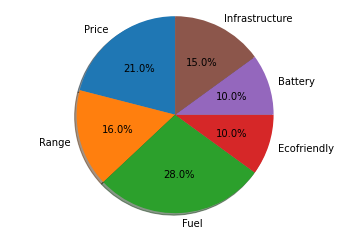

In [45]:
import matplotlib.pyplot as plt

labels = ['Price','Range','Fuel','Ecofriendly','Battery','Infrastructure']
listValues = list(ll.select('count').toPandas()['count'])
sum = 0
for item in listValues:
   sum += item
    
print(sum)

listValues = [(number / sum)*100 for number in listValues]

fig1, ax1 = plt.subplots()
ax1.pie(listValues, labels=labels ,autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [46]:
ll = df3.groupBy("Dominant_Topic","Sentiment").count()
ll = ll.orderBy(col("Dominant_Topic").asc())
ll = ll.orderBy(col("Dominant_Topic").asc())
ll.show()

21/12/10 11:53:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+---------+-----+
|Dominant_Topic|Sentiment|count|
+--------------+---------+-----+
|           0.0|        1|   13|
|           0.0|        0|    8|
|           1.0|       -1|    3|
|           1.0|        0|    6|
|           1.0|        1|    7|
|           2.0|        0|   11|
|           2.0|        1|   13|
|           2.0|       -1|    4|
|           3.0|       -1|    1|
|           3.0|        0|    3|
|           3.0|        1|    6|
|           4.0|        0|    5|
|           4.0|        1|    3|
|           4.0|       -1|    2|
|           5.0|       -1|    1|
|           5.0|        1|    7|
|           5.0|        0|    7|
+--------------+---------+-----+

